Разработано Драчуком А. для The Foundation
Следите за нами в Телеграм: @LYFTN

In [189]:
# Импорт данных по выбранным для портфеля акциям с Quandl
# Можно также использовать любой другой источник: файл ".csv" на локальном диске или Yahoo Finance, Google Finance, Morningstar, IEX, Robinhood, Engima, FRED, World Ban, OECD и т.д.
# Подключение API Quandl:
quandl.ApiConfig.api_key = "c4nWBNKbsz2TsPb8R7Cb"

# Здесь необходимо указать тикеры акций, данные по которым мы хотим импортировать
# AMD -- Advanced Micro Devices, Inc.
# ATVI -- Activision
# INTC -- Intel Corporation
# EA -- Electronic Arts Inc.
stocks = ['AMD', 'ATVI', 'INTC', 'EA']

# Импорт данных. Моделирование производится для доступных данных. 
# Данные по другим тикерам / другой период требуют платной подписки на https://data.nasdaq.com/search
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                       qopts = {'columns': ['date', 'ticker', 'adj_close']}, 
                       date = {'gte': '2016-1-1', 'lte': '2017-12-31'}, paginate = True)

# Проверка работы импорта данных по акциям (отображаются первые 5 результатов)
data.head()

,date,ticker,adj_close
None,,,
0,2017-12-29,INTC,46.16
1,2017-12-28,INTC,46.22
2,2017-12-27,INTC,46.11
3,2017-12-26,INTC,46.08
4,2017-12-22,INTC,46.70


In [190]:
# Замена в таблице индекса строки на дату
df = data.set_index('date')
df.head()

,ticker,adj_close
date,,
2017-12-29,INTC,46.16
2017-12-28,INTC,46.22
2017-12-27,INTC,46.11
2017-12-26,INTC,46.08
2017-12-22,INTC,46.70


In [191]:
# Замена заголовков столбцов на тикеры
table = df.pivot(columns = 'ticker')
table.columns = [col[1] for col in table.columns]
table.head()

,AMD,ATVI,EA,INTC
date,,,,
2016-01-04,2.770,37.094471,66.10,31.810946
2016-01-05,2.750,36.621176,64.94,31.661204
2016-01-06,2.505,36.276065,63.68,30.959285
2016-01-07,2.275,35.763330,62.46,29.798780
2016-01-08,2.140,35.211152,63.13,29.489936


Text(0, 0.5, 'Цена акций в USD')

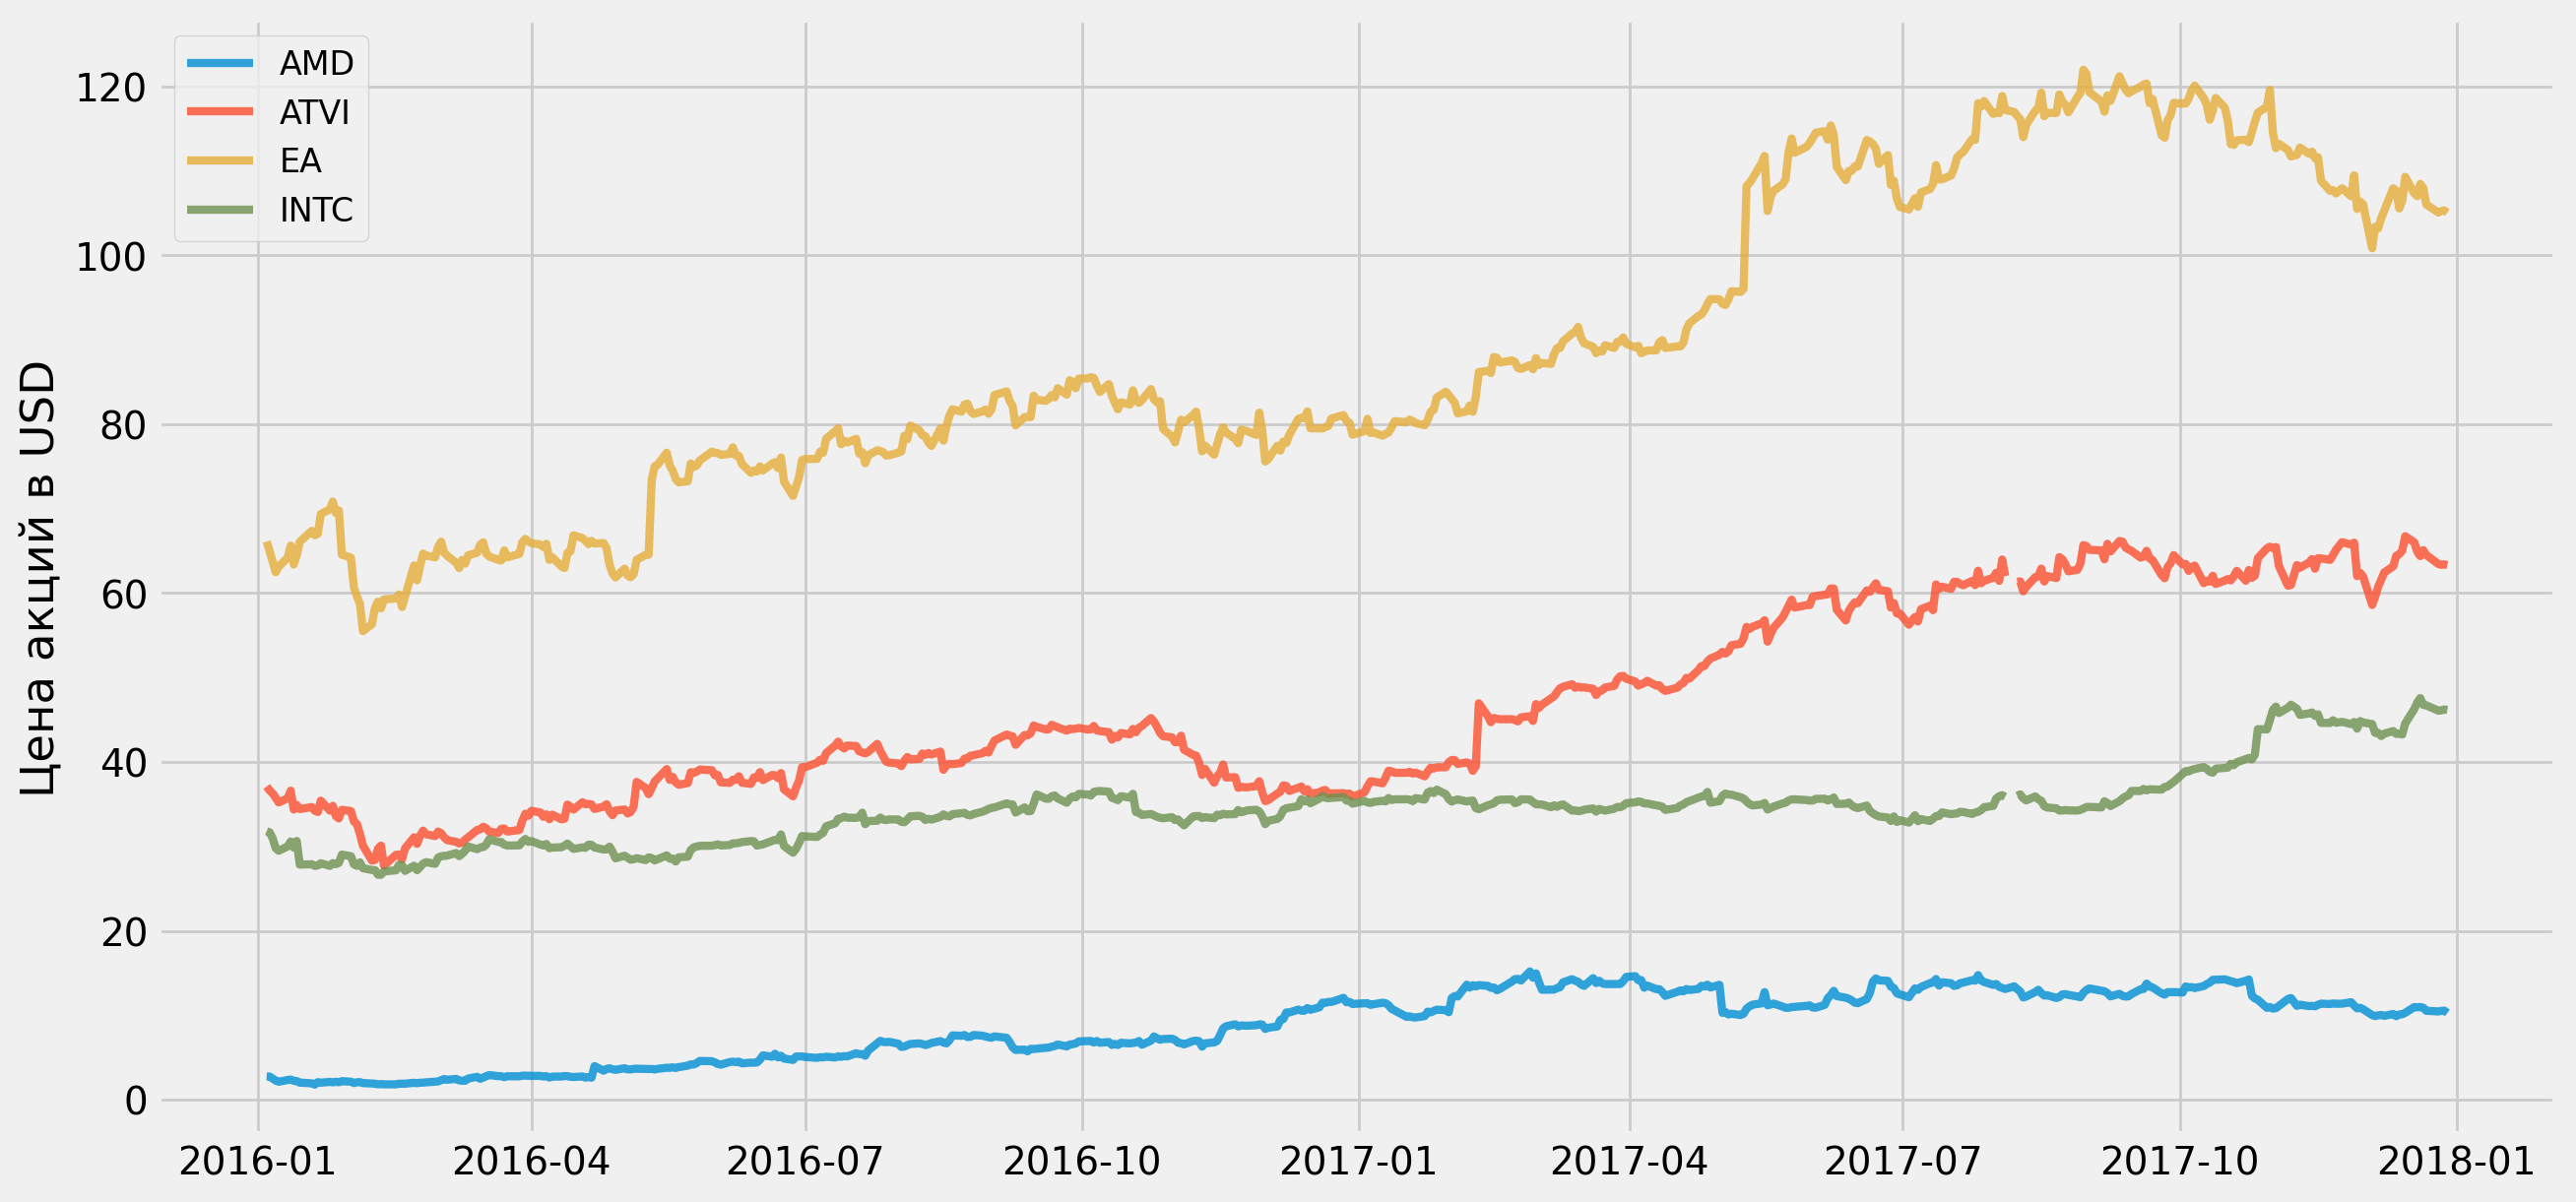

In [192]:
# Формирование графика изменения цен на рассматриваемом периоде
plt.figure(figsize = (14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw = 3, alpha = 0.8, label = c)
plt.legend(loc='upper left', fontsize = 12)
plt.ylabel('Цена акций в USD')

In [193]:
# Моделирование кривой эффективных инвестиционных портфелей

# Импортируем необходимыхе библиотеки. 
# Если какой-то библиотеки нет, необходимо ее установить через терминал командой: pip install библиотека 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import quandl

plt.style.use('fivethirtyeight') # применяем стиль из галереи: https://matplotlib.org/stable/gallery/index.html

# Настройки отображения высокого разрешения для jupiter notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Text(0, 0.5, 'Дневная доходность акций')

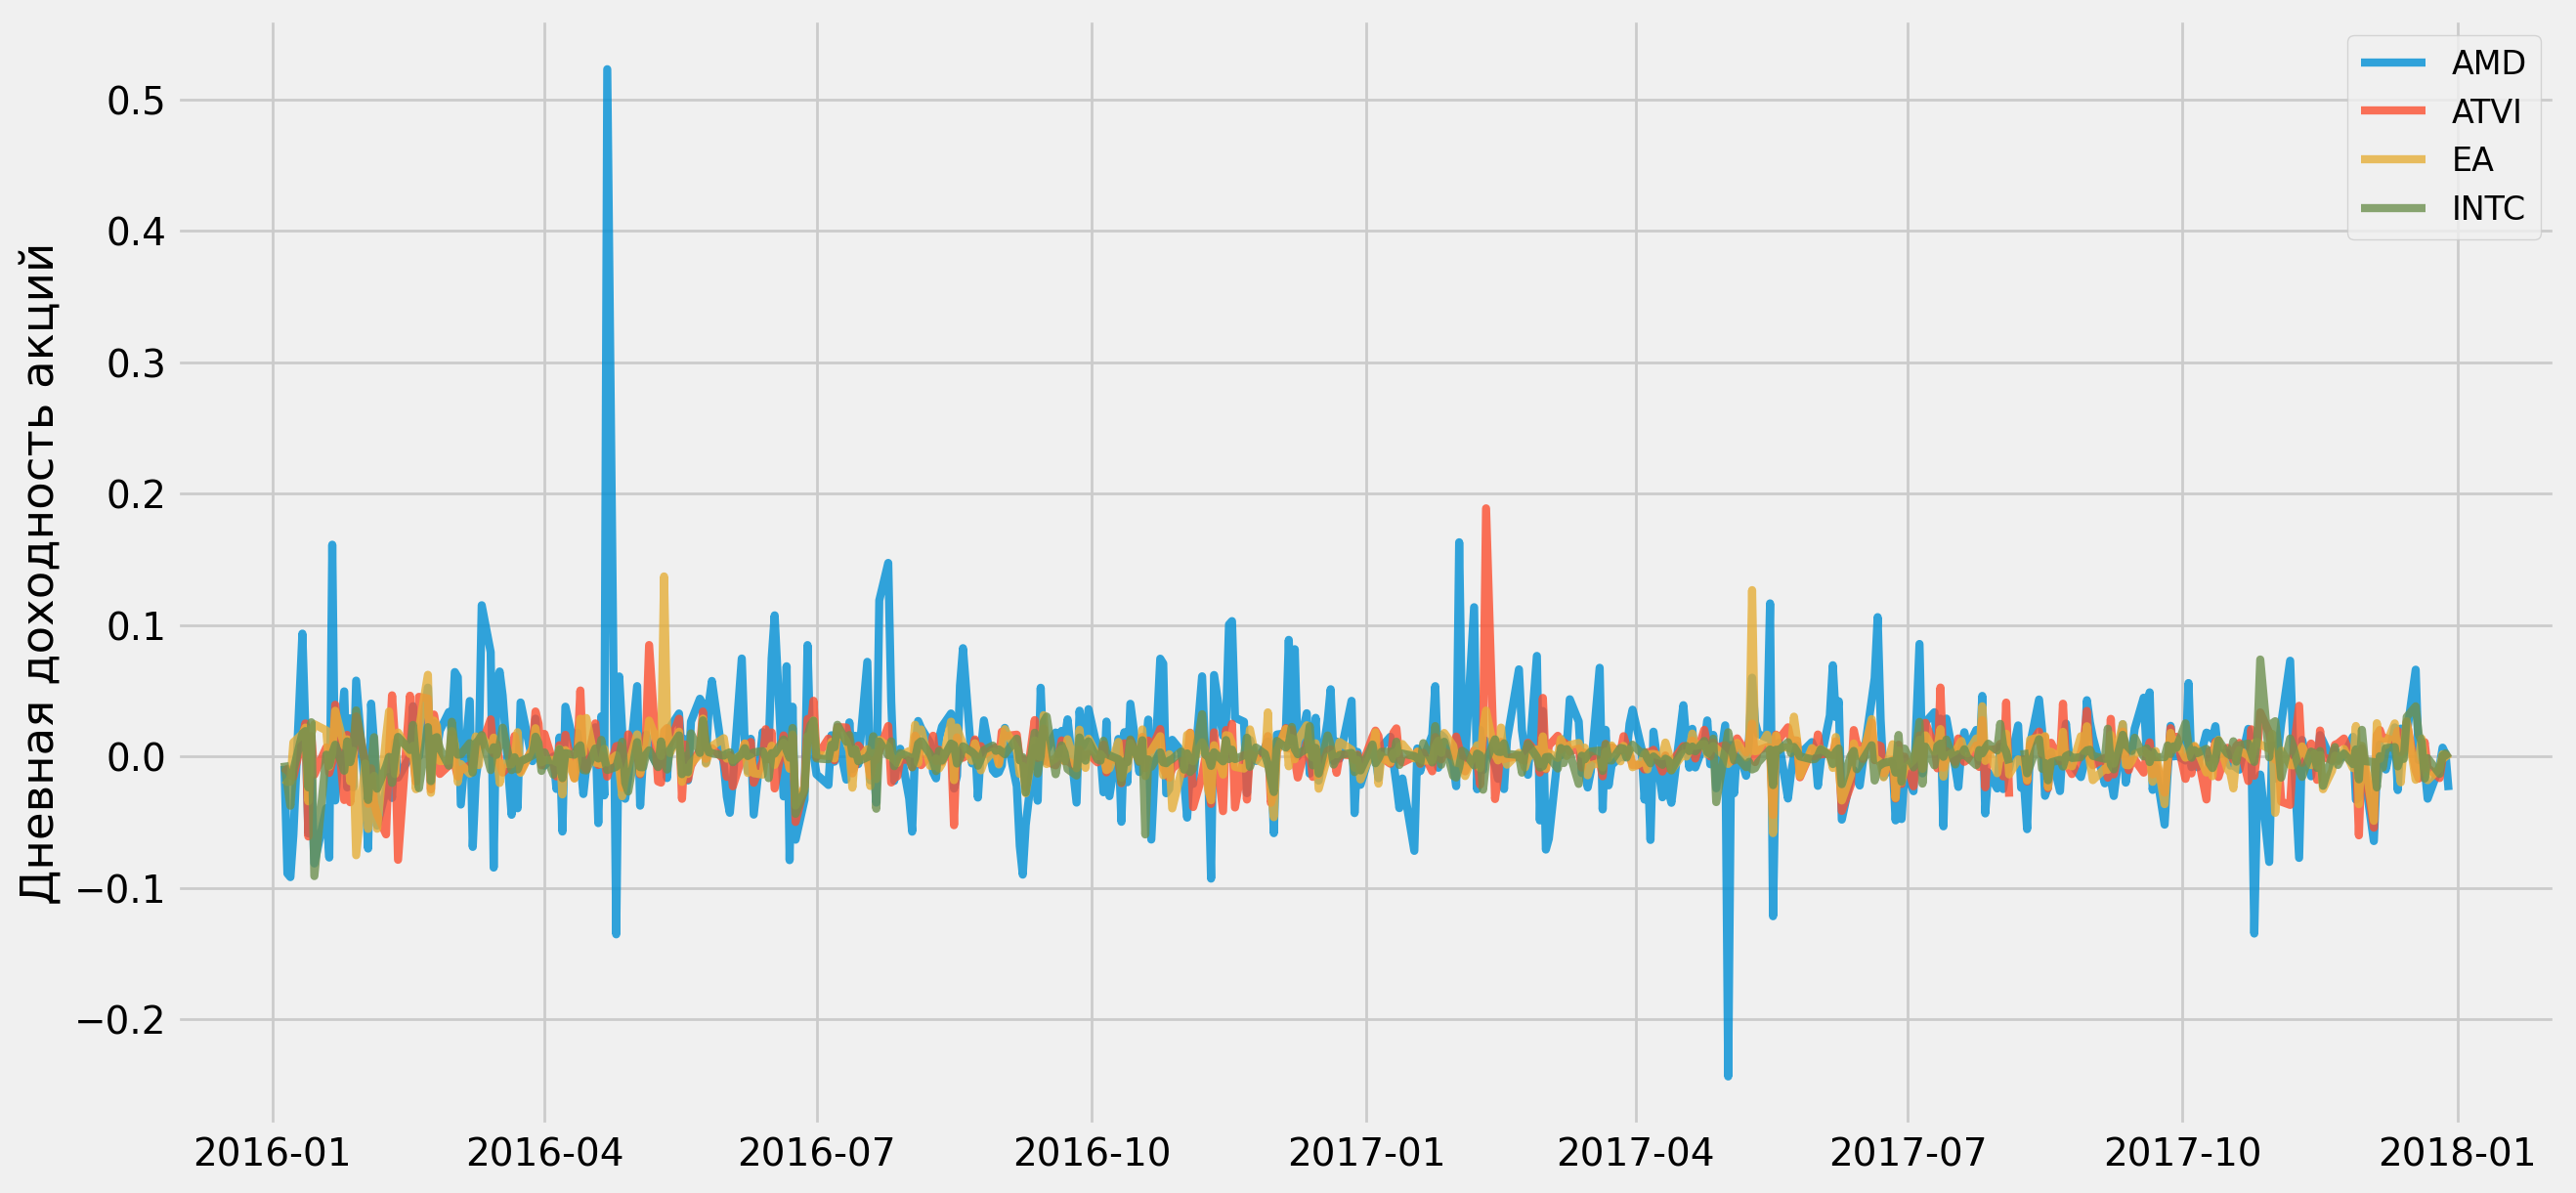

In [194]:
# Расчет дневной доходности акций
returns = table.pct_change(fill_method = None)

# Формирование графика дневной доходности акций
plt.figure(figsize = (14,7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw = 3, alpha = 0.8, label = c)
plt.legend(loc = 'upper right', fontsize = 12)
plt.ylabel('Дневная доходность акций')

Для формирования кривой эффективных инвестиционных портфелей, а также нахождения оптимального инвестиционного портфеля необходимо сгенерировать несколько инвестиционных портфелей со случайно заданными весами, которые будут формировать пространство доступных портфелей. 

В коде ниже в переменной num_porfolios мы задаем кол-во портфелей (случайных итераций). В нашем примере 10 000 портфелей.

Оптимальными портфель определяется по одному из двух признаков:
1) Максимальная доходность -- здесь в качестве критерия используем коэффициент Шарпа как меру премии за рыночный риск. Оптимальным будет портфель с максимальным значением коэффициента Шарпа;
2) Минимальная волатильность -- здесь в качестве критерия используем риск (стандартное отклонение) портфеля. Оптимальным будет портфель с минимальным уровнем риска.

Для приведения дневных значений дневных доходности и стандартного отклонения к годовому исчислению используем 252 дня как среднее кол-во торговых дней в году

In [195]:
# Приведение значенией дневных доходности и стандартного отклонения к годовому исчислению
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252 
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns 

In [196]:
# Входные параметры для моделирования случайных инвестиционных портфелей
returns = table.pct_change(fill_method = None)
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_porfolios = 10000 # кол-во инвестиционных портфелей со случайными весами
risk_free_rate = 0.05 # безрисковая ставка для расчета коэффициента Шарпа

# Функция генератора случайных портфелей в виде матрицы
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))  # создаем нулевую матрицу для моделируемых портфелей, где строки - параметры, а столбцы индекс случайного портфеля 
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4) # поскольку в портфель включены 4 инструмента, веса тоже находятся для 4 инструментов
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev # первая строка матрицы -- ст. откл. портфеля в конкретном столбце
        results[1,i] = portfolio_return  # вторая строка матрицы -- годовая доходность портфеля 
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev # третья строка матрицы -- коэффициент Шарпа
    return results, weights_record

После генерации случайных портфелей, необходимо определить оптимальные портфели в годовом исчислении (максимальный коэффициент Шарпа и минимальный риск), а также отобразить веса входящих в них инструментов: 

In [197]:
# Определяем портфели с максимальным коэффициентом Шарпа и минимальным риском, 
# а также визуализируем результаты моделирования
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
    
    # Находим портфель с максимальным значением коэффициента Шарпа
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index = table.columns, columns = ['allocation'])
    max_sharpe_allocation.allocation = [round(i * 100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # Находим портфель с минимальной волатильнойстью (риском)
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0, min_vol_idx], results[1, min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx], index = table.columns, columns = ['allocation'])
    min_vol_allocation.allocation = [round(i * 100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    # Формируем таблицу
    print('-' * 80)
    print('\n')
    print('\033[1m' + 'Портфель с максимальным значением коэффициента Шарпа\n')
    print('\033[0m' + 'Годовая доходность: ', round(rp,2))
    print('Годовая волатильность (риск): ', round(sdp, 2))
    print('\n')
    print('Веса инструментов в портфеле: ')
    print(max_sharpe_allocation)
    print('\n')
    print('-' * 80)
    print('\n')
    print('\033[1m' + 'Портфель с минимальной волатильностью (риском)\n')
    print('\033[0m' + 'Годовая доходность: ', round(rp_min,2))
    print('Годовая волатильность (риск): ', round(sdp_min, 2))
    print('\n')
    print('Веса инструментов в портфеле: ')
    print(min_vol_allocation)
    print('\n')
    print('-' * 80)
    print('\n')

    # Формируем график с результатами моделирования
    plt.figure(figsize = (10, 7))
    plt.scatter(results[0,:], results[1,:], c = results[2, :], cmap = 'coolwarm', marker = 'o', s = 10, alpha = 0.3)
    plt.colorbar()
    plt.scatter(sdp, rp, marker = '*', color = 'r', s = 500, label = 'Максимальное значение коэффициента Шарпа')
    plt.scatter(sdp_min, rp_min, marker = '*', color = 'g', s = 500, label = 'Минимальная волатильность (риск)')
    plt.rcParams.update({'font.size': 10})
    plt.title('Поиск оптимального портфеля на основе моделирования кривой эффективных инвестиционных портфелей')
    plt.rcParams.update({'font.size': 10})
    plt.xlabel('Волатильность (риск) в годовом исчислении')
    plt.ylabel('Доходность в годовом исчислении')
    plt.legend(labelspacing = 0.8)

--------------------------------------------------------------------------------


Портфель с максимальным значением коэффициента Шарпа

Годовая доходность:  0.41
Годовая волатильность (риск):  0.25


Веса инструментов в портфеле: 
              AMD   ATVI     EA   INTC
allocation  22.75  24.67  19.55  33.03


--------------------------------------------------------------------------------


Портфель с минимальной волатильностью (риском)

Годовая доходность:  0.24
Годовая волатильность (риск):  0.18


Веса инструментов в портфеле: 
             AMD  ATVI    EA   INTC
allocation  0.08  8.26  29.5  62.17


--------------------------------------------------------------------------------




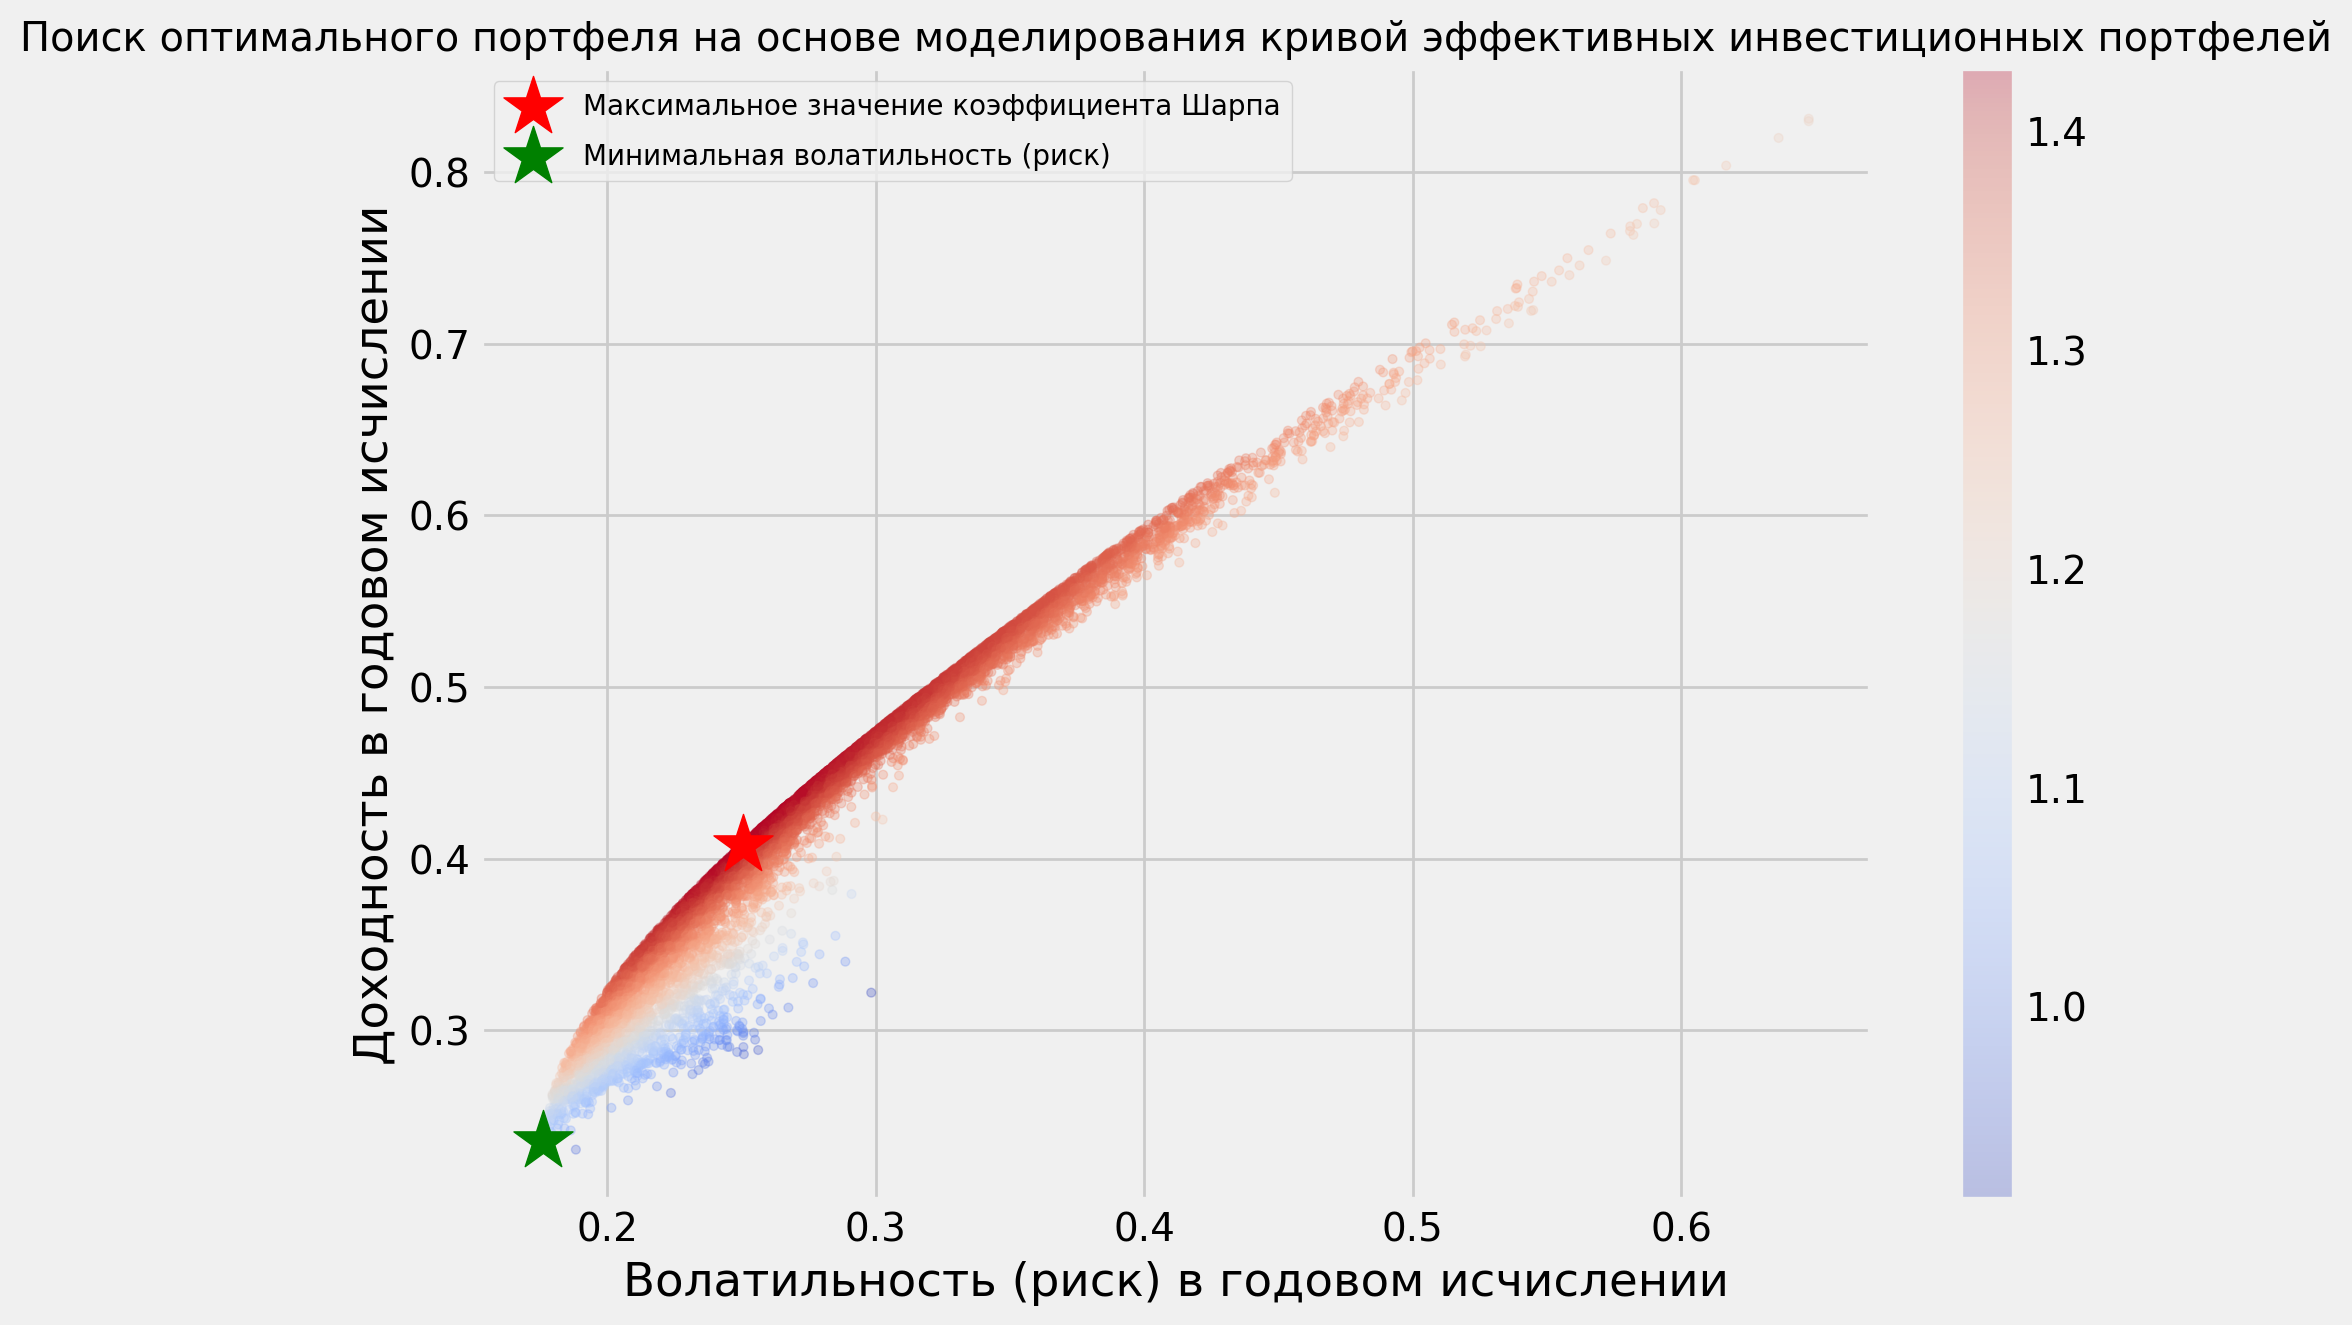

In [198]:
# Отображаем график
display_simulated_ef_with_random(mean_returns, cov_matrix, num_porfolios, risk_free_rate)